# Amazon Product Data Science Challenge

The challenge is posed by KeepUp and involves a dataset from Amazon. KeepUp is an edTech startup based in San Francisco. Founded in 2012 by Rick Sindhwani, it curates educational resources to help companies rapidly train their employees and keep up with changing times and trends.

**Data source:** http://snap.stanford.edu/data/amazon-meta.html 

**Data entry format:**
* Id: Product id (number 0, ..., 548551) 
* ASIN: Amazon Standard Identification Number 
* title: Name/title of the product 
* group: Product group (Book, DVD, Video or Music) 
* salesrank: Amazon Salesrank 
* similar: ASINs of co-purchased products (people who buy X also buy Y) 
* categories: Location in product category hierarchy to which the product belongs 
(separated by |, category id in [ ]) 
* reviews: Product review information: time, user id, rating, total number of votes on the 
review, total number of helpfulness votes (how many people found the review to 
be helpful) 

## Exploratory Analysis

With the given data for 548,552 products, perform exploratory analysis and make 
suggestions for further analysis on the following aspects.  

### Trustworthiness of ratings  

Ratings are susceptible to manipulation or bias by companies who hire people to write fake reviews in order to push sales. One challenge for Amazon is to identify the instances of fake reviews. Here are a few possible cases when companies want to increase sales on a timeline:

* A lot of positive reviews happens within a few days of each other
* The same person (who is then hired) writes many reviews within a few days

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
reviews_dict = {'id': [], 'asin': [], 'date': [], 'customer': [], 'rating': []}

with open('amazon-meta.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('Id'):
            Id = line.split()[1]
        elif line.startswith('ASIN'):
            ASIN = line.split()[1]
        elif line.startswith('    '):
            review = line.split()
            reviews_dict['id'].append(int(Id))
            reviews_dict['asin'].append(ASIN)
            reviews_dict['date'].append(review[0])
            reviews_dict['customer'].append(review[2])
            reviews_dict['rating'].append(int(review[4]))

df = pd.DataFrame.from_dict(reviews_dict)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593244 entries, 0 to 7593243
Data columns (total 5 columns):
asin        object
customer    object
date        datetime64[ns]
id          int64
rating      int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 289.7+ MB


In [3]:
df = pd.DataFrame.from_dict(reviews_dict)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593244 entries, 0 to 7593243
Data columns (total 5 columns):
asin        object
customer    object
date        datetime64[ns]
id          int64
rating      int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 289.7+ MB


In [4]:
df.head(10)

,asin,customer,date,id,rating
0,0827229534,A2JW67OY8U6HHK,2000-07-28,1,5
1,0827229534,A2VE83MZF98ITY,2003-12-14,1,5
2,0738700797,A11NCO6YTE4BTJ,2001-12-16,2,5
3,0738700797,A9CQ3PLRNIR83,2002-01-07,2,4
4,0738700797,A13SG9ACZ9O5IM,2002-01-24,2,5
5,0738700797,A1BDAI6VEYMAZA,2002-01-28,2,5
6,0738700797,A2P6KAWXJ16234,2002-02-06,2,4
7,0738700797,AMACWC3M7PQFR,2002-02-14,2,4
8,0738700797,A3GO7UV9XX14D8,2002-03-23,2,4
9,0738700797,A1GIL64QK68WKL,2002-05-23,2,5


In [5]:
# Count the number of reviews per day for each product and its average rating
df_date = df.groupby(['id', 'date'])['rating'].agg([np.size, np.mean]).sort_values(by='size', ascending=False).reset_index()
df_date.head(10)

,id,date,size,mean
0,258380,2003-06-22,736,4.664402
1,519891,2003-06-22,736,4.663043
2,6130,2003-06-22,736,4.669837
3,429348,2003-06-22,736,4.660326
4,527309,2000-07-09,705,4.828369
5,429123,2000-07-09,705,4.828369
6,311376,2000-07-09,705,4.822695
7,84842,2000-07-09,705,4.822695
8,4739,2000-07-09,705,4.831206
9,544342,2000-07-09,705,4.828369


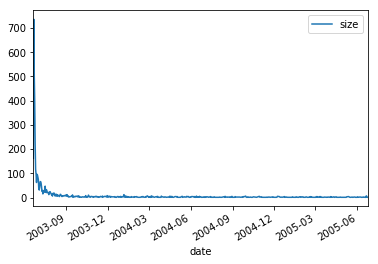

In [6]:
# A lot of reviews tend to happen at the beginning, so it could simply 
# be that the products were newly released and caused many people to write about them
product = 258380

df_date.loc[df_date['id']==product].sort_values('date').plot(x='date', y='size')

In [7]:
# Count the number of reviews written per customer for each day
# A single customer wrote thousands of reviews for many days 

df_person = df.groupby(['customer', 'date'])['rating'].agg([np.size, np.mean]).sort_values(by='size', ascending=False).reset_index()
df_person.head(10)

,customer,date,size,mean
0,ATVPDKIKX0DER,1998-08-22,4981,4.351737
1,ATVPDKIKX0DER,1999-11-08,2837,4.326049
2,ATVPDKIKX0DER,1999-11-16,2650,4.336981
3,ATVPDKIKX0DER,1999-11-03,2616,4.247706
4,ATVPDKIKX0DER,1999-11-02,2575,4.316505
5,ATVPDKIKX0DER,1999-06-29,2528,4.312104
6,ATVPDKIKX0DER,1999-04-14,2521,4.196747
7,ATVPDKIKX0DER,1999-11-04,2459,4.311509
8,ATVPDKIKX0DER,1999-07-06,2449,4.319314
9,ATVPDKIKX0DER,1999-10-24,2448,4.161765


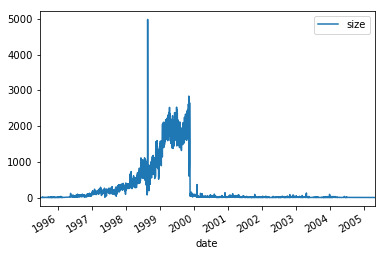

In [8]:
# This time series shows that this cusomter wrote thousands of reviews consistently 
# for about a year and half from mid 1998 to the end of 1999 and then sudden stopped writing as much
customer = 'ATVPDKIKX0DER'

df_person.loc[df_person['customer']==customer].sort_values('date').plot(x='date', y='size')

### Category bloat  
Consider the product group named 'Books'. Each product in this group is associated with 
categories. Naturally, with categorization, there are tradeoffs between how broad or 
specific the categories must be.  

For this dataset, quantify the following: 
1. Is there redundancy in the categorization? How can it be identified/removed? 
2. Is it possible to reduce the number of categories drastically (say to 10% of existing 
categories) by sacrificing relatively few unique categories (say close to 10%)? 

In [9]:
books_dict = {'id': [], 'title': [], 'cat_depth': [], 'category': []}

with open('amazon-meta.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('Id'):
            product = line.split()[1]
        elif line.startswith('  title'):
            title = line.split()[1]
        elif line.startswith('  group'):
            group = line.split()[1]
        elif line.startswith('   |') and group=='Book':
            books_dict['id'].append(int(product))
            books_dict['title'].append(title)
            cat = line.split("|")[1:]
            books_dict['cat_depth'].append(int(len(cat)))
            books_dict['category'].append(line)

In [10]:
df_books = pd.DataFrame.from_dict(books_dict)
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440329 entries, 0 to 1440328
Data columns (total 4 columns):
cat_depth    1440329 non-null int64
category     1440329 non-null object
id           1440329 non-null int64
title        1440329 non-null object
dtypes: int64(2), object(2)
memory usage: 44.0+ MB


In [11]:
df_books.head()

,cat_depth,category,id,title
0,6,|Books[283155]|Subjects[1000]|Religion & Sp...,1,Patterns
1,6,|Books[283155]|Subjects[1000]|Religion & Sp...,1,Patterns
2,5,|Books[283155]|Subjects[1000]|Religion & Sp...,2,Candlemas:
3,5,|Books[283155]|Subjects[1000]|Religion & Sp...,2,Candlemas:
4,5,|Books[283155]|Subjects[1000]|Home & Garden...,3,World


In [12]:
categories = df_books.groupby(['category']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).reset_index()
categories.head()

,index,category,count
0,11878,|[265523]|Amazon.com Stores[285080]|Home & ...,18438
1,1877,|Books[283155]|Subjects[1000]|Business & In...,18436
2,8668,|Books[283155]|Subjects[1000]|Reference[21]...,13701
3,1605,|Books[283155]|Subjects[1000]|Biographies &...,12241
4,7829,|Books[283155]|Subjects[1000]|Nonfiction[53...,11779


In [13]:
entries = df_books.shape[0]
unique = categories.shape[0]
print('The total number of category entires for all books: {}'.format(entries))
print('The total number of different (or unique) categories: {}'.format(unique))

The total number of category entires for all books: 1440329
The total number of different (or unique) categories: 12853


In [14]:
# Print out the broadest 5 categories and they are all general categories
for i in range(5):
    print(i, categories.iloc[i].category)

0    |[265523]|Amazon.com Stores[285080]|Home & Office[764512]|Business & Investing Books[767740]|General[767880]

1    |Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]

2    |Books[283155]|Subjects[1000]|Reference[21]|General[408268]

3    |Books[283155]|Subjects[1000]|Biographies & Memoirs[2]|General[2375]

4    |Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]



In [15]:
# Eliminate 10% of the broadest categories will remove more than 70% of all category entries.
threshold = round(0.1 * unique)
broadest = categories.iloc[:threshold].category
removed = sum(df_books.category.isin(broadest))
print('Remove {} broadest cateogories will reduce the total number of category entries by {}.'.format(threshold, removed))

Remove 1285 broadest cateogories will reduce the total number of category entries by 1033423.


In [16]:
print('Elimiate only 10% of the broadest catogories will reduce {:.1f}% of all category entries.'.format(removed/entries*100))

Elimiate only 10% of the broadest catogories will reduce 71.7% of all category entries.
